# **Toronto Crime Predictions**

In [20]:
# Dependencies
import requests
import json
import pprint
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import DBSCAN

---

## **Retrieve Data from API**

In [28]:
# Initialize the base URL and the initial parameters
base_url = 'https://services.arcgis.com/S9th0jAJ7bqgIRjw/ArcGIS/rest/services/Major_Crime_Indicators_Open_Data/FeatureServer/0/query'
params = {
    'where': 'OCC_YEAR<=2024 AND OCC_YEAR>=2021',
    'outFields': '*',
    'resultRecordCount': 2000,
    'resultOffset': 0,
    'f': 'geojson'
}
# Create an empty list to store all the results
crime_json_array = []
# Start the loop to paginate through the results
while True:
    response = requests.get(base_url, params=params).json()
    # Add the current batch of features to the list
    crime_json_array.extend(response['features'])
    # Check if 'exceededTransferLimit' is True, which means there are more records
    if 'properties' in response and response['properties'].get('exceededTransferLimit', False):
        # Increment the offset to get the next batch of records
        params['resultOffset'] += params['resultRecordCount']
    else:
        # Exit the loop if there are no more records to retrieve
        break

In [ ]:
# View the raw JSON data
crime_json_array

In [ ]:
def arrange_crime_json_array(crime):
    """ Function for filtering out the API query metdata, and getting a JSON list of just the crime data"""
    crime_case = crime['properties']
    return crime_case

In [ ]:
# Using a list comprehension to apply the function for each entry in the intial crime JSON array.
crime_json_list = [arrange_crime_json_array(crime) for crime in crime_json_array]
crime_json_list

[{'OBJECTID': 246675,
  'EVENT_UNIQUE_ID': 'GO-20213605',
  'REPORT_DATE': 1609477200000,
  'OCC_DATE': 1609477200000,
  'REPORT_YEAR': 2021,
  'REPORT_MONTH': 'January',
  'REPORT_DAY': 1,
  'REPORT_DOY': 1,
  'REPORT_DOW': 'Friday    ',
  'REPORT_HOUR': 16,
  'OCC_YEAR': 2021,
  'OCC_MONTH': 'January',
  'OCC_DAY': 1,
  'OCC_DOY': 1,
  'OCC_DOW': 'Friday    ',
  'OCC_HOUR': 16,
  'DIVISION': 'D13',
  'LOCATION_TYPE': 'Parking Lots (Apt., Commercial Or Non-Commercial)',
  'PREMISES_TYPE': 'Outside',
  'UCR_CODE': 2135,
  'UCR_EXT': 210,
  'OFFENCE': 'Theft Of Motor Vehicle',
  'MCI_CATEGORY': 'Auto Theft',
  'HOOD_158': '094',
  'NEIGHBOURHOOD_158': 'Wychwood (94)',
  'HOOD_140': '094',
  'NEIGHBOURHOOD_140': 'Wychwood (94)',
  'LONG_WGS84': -79.42576192637651,
  'LAT_WGS84': 43.68176901263976},
 {'OBJECTID': 246676,
  'EVENT_UNIQUE_ID': 'GO-20213400',
  'REPORT_DATE': 1609477200000,
  'OCC_DATE': 1609477200000,
  'REPORT_YEAR': 2021,
  'REPORT_MONTH': 'January',
  'REPORT_DAY': 1,
  

In [ ]:
# Convert the JSON array into a Dataframe
crime_data_original = pd.DataFrame(crime_json_list)
crime_data_original



---



## **Preprocess the Data**

In [ ]:
# Get all the column names in crime_data_original
crime_data_original.columns

Index(['OBJECTID', 'EVENT_UNIQUE_ID', 'REPORT_DATE', 'OCC_DATE', 'REPORT_YEAR',
       'REPORT_MONTH', 'REPORT_DAY', 'REPORT_DOY', 'REPORT_DOW', 'REPORT_HOUR',
       'OCC_YEAR', 'OCC_MONTH', 'OCC_DAY', 'OCC_DOY', 'OCC_DOW', 'OCC_HOUR',
       'DIVISION', 'LOCATION_TYPE', 'PREMISES_TYPE', 'UCR_CODE', 'UCR_EXT',
       'OFFENCE', 'MCI_CATEGORY', 'HOOD_158', 'NEIGHBOURHOOD_158', 'HOOD_140',
       'NEIGHBOURHOOD_140', 'LONG_WGS84', 'LAT_WGS84'],
      dtype='object')

In [ ]:
# Collect only the necessary columns for the analysis
crime_pd = crime_data_original[['EVENT_UNIQUE_ID', 'NEIGHBOURHOOD_158', 'LAT_WGS84', 'LONG_WGS84', 'PREMISES_TYPE', 'OCC_DATE', 'OCC_YEAR', 'OCC_MONTH', 'OCC_DAY', 'OCC_HOUR', 'MCI_CATEGORY']]
crime_pd


,EVENT_UNIQUE_ID,NEIGHBOURHOOD_158,LAT_WGS84,LONG_WGS84,PREMISES_TYPE,OCC_DATE,OCC_YEAR,OCC_MONTH,OCC_DAY,OCC_HOUR,MCI_CATEGORY
0,GO-20213605,Wychwood (94),43.681769,-79.425762,Outside,1609477200000,2021,January,1,16,Auto Theft
1,GO-20213400,NSA,0.000000,0.000000,Commercial,1609477200000,2021,January,1,4,Auto Theft
2,GO-20211123,Yorkdale-Glen Park (31),43.721013,-79.460110,Other,1609477200000,2021,January,1,4,Auto Theft
3,GO-2021445,Yonge-Doris (151),43.778743,-79.415293,Other,1609477200000,2021,January,1,1,Auto Theft
4,GO-20213400,NSA,0.000000,0.000000,Commercial,1609477200000,2021,January,1,4,Auto Theft
...,...,...,...,...,...,...,...,...,...,...,...
147546,GO-20241427047,Cabbagetown-South St.James Town (71),43.663195,-79.373043,Apartment,1719637200000,2024,June,29,23,Assault
147547,GO-20241427869,York University Heights (27),43.759469,-79.464942,Commercial,1719723600000,2024,June,30,18,Theft Over
147548,GO-20241423116,Morningside Heights (144),43.837237,-79.248477,Outside,1719637200000,2024,June,29,21,Assault
147549,GO-20241426669,Mimico-Queensway (160),43.616490,-79.521053,Outside,1718859600000,2024,June,20,13,Theft Over


In [ ]:
# Encode the MCI_CATEGORY column using get_dummies
crime_category_encoded = pd.get_dummies(crime_pd['MCI_CATEGORY']).astype(int)
crime_category_encoded


,Assault,Auto Theft,Break and Enter,Robbery,Theft Over
0,0,1,0,0,0
1,0,1,0,0,0
2,0,1,0,0,0
3,0,1,0,0,0
4,0,1,0,0,0
...,...,...,...,...,...
147546,1,0,0,0,0
147547,0,0,0,0,1
147548,1,0,0,0,0
147549,0,0,0,0,1


In [ ]:
# Add the encoded columns back into the datframe
crime_pd = pd.concat([crime_pd, crime_category_encoded], axis=1)
crime_pd_encoded = crime_pd.drop(['MCI_CATEGORY'], axis=1) # Drop the original MCI_CATEGORY column
crime_pd_encoded

,EVENT_UNIQUE_ID,NEIGHBOURHOOD_158,LAT_WGS84,LONG_WGS84,PREMISES_TYPE,OCC_DATE,OCC_YEAR,OCC_MONTH,OCC_DAY,OCC_HOUR,Assault,Auto Theft,Break and Enter,Robbery,Theft Over
0,GO-20213605,Wychwood (94),43.681769,-79.425762,Outside,1609477200000,2021,January,1,16,0,1,0,0,0
1,GO-20213400,NSA,0.000000,0.000000,Commercial,1609477200000,2021,January,1,4,0,1,0,0,0
2,GO-20211123,Yorkdale-Glen Park (31),43.721013,-79.460110,Other,1609477200000,2021,January,1,4,0,1,0,0,0
3,GO-2021445,Yonge-Doris (151),43.778743,-79.415293,Other,1609477200000,2021,January,1,1,0,1,0,0,0
4,GO-20213400,NSA,0.000000,0.000000,Commercial,1609477200000,2021,January,1,4,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147546,GO-20241427047,Cabbagetown-South St.James Town (71),43.663195,-79.373043,Apartment,1719637200000,2024,June,29,23,1,0,0,0,0
147547,GO-20241427869,York University Heights (27),43.759469,-79.464942,Commercial,1719723600000,2024,June,30,18,0,0,0,0,1
147548,GO-20241423116,Morningside Heights (144),43.837237,-79.248477,Outside,1719637200000,2024,June,29,21,1,0,0,0,0
147549,GO-20241426669,Mimico-Queensway (160),43.616490,-79.521053,Outside,1718859600000,2024,June,20,13,0,0,0,0,1


In [ ]:
# Group the values by EVENT_UNIQUE_ID and get the first value for all the columns, except for Assault, Auto Theft, Break and Enter, Robbery, Theft Over
crime_first_group = crime_pd_encoded.groupby('EVENT_UNIQUE_ID')[["NEIGHBOURHOOD_158", "LAT_WGS84", "LONG_WGS84", "PREMISES_TYPE", "OCC_DATE", "OCC_YEAR", "OCC_MONTH", "OCC_DAY", "OCC_HOUR"]].first()
crime_first_group

,NEIGHBOURHOOD_158,LAT_WGS84,LONG_WGS84,PREMISES_TYPE,OCC_DATE,OCC_YEAR,OCC_MONTH,OCC_DAY,OCC_HOUR
EVENT_UNIQUE_ID,,,,,,,,,
GO-20211000033,West Queen West (162),43.646286,-79.408568,Commercial,1622264400000,2021,May,29,21
GO-2021100004,Morningside Heights (144),43.807252,-79.162903,Outside,1610773200000,2021,January,16,17
GO-20211000054,Moss Park (73),43.657067,-79.374531,Apartment,1622264400000,2021,May,29,22
GO-20211000193,Fort York-Liberty Village (163),43.636618,-79.399704,Apartment,1622264400000,2021,May,29,23
GO-20211000248,Eglinton East (138),43.737099,-79.246230,Outside,1622264400000,2021,May,29,21
...,...,...,...,...,...,...,...,...,...
GO-20249997,Junction-Wallace Emerson (171),43.668917,-79.442637,Outside,1704085200000,2024,January,1,18
GO-202499972,Edenbridge-Humber Valley (9),43.672705,-79.522472,House,1705208400000,2024,January,14,3
GO-2024999786,Flemingdon Park (44),43.718727,-79.334948,Apartment,1714539600000,2024,May,1,0


In [ ]:
# Group the MCI_CATEGORY values by EVENT_UNIQUE_ID and get the maximum value.
crime_max_group = crime_pd_encoded.groupby('EVENT_UNIQUE_ID')[["Assault", "Auto Theft", "Break and Enter", "Robbery", "Theft Over"]].max()
crime_max_group

,Assault,Auto Theft,Break and Enter,Robbery,Theft Over
EVENT_UNIQUE_ID,,,,,
GO-20211000033,0,0,1,0,0
GO-2021100004,0,1,0,0,0
GO-20211000054,1,0,0,0,0
GO-20211000193,1,0,0,0,0
GO-20211000248,1,0,0,0,0
...,...,...,...,...,...
GO-20249997,0,1,0,0,0
GO-202499972,0,1,0,0,0
GO-2024999786,1,0,0,0,0


In [ ]:
# Concatenate the two groups together into one Dataframe and reset the index so that EVENT_UNIQUE_ID is not the index.
crime_groups_joined = pd.concat([crime_first_group, crime_max_group], axis=1)
crime_groups_joined = crime_groups_joined.reset_index()
crime_groups_joined

,EVENT_UNIQUE_ID,NEIGHBOURHOOD_158,LAT_WGS84,LONG_WGS84,PREMISES_TYPE,OCC_DATE,OCC_YEAR,OCC_MONTH,OCC_DAY,OCC_HOUR,Assault,Auto Theft,Break and Enter,Robbery,Theft Over
0,GO-20211000033,West Queen West (162),43.646286,-79.408568,Commercial,1622264400000,2021,May,29,21,0,0,1,0,0
1,GO-2021100004,Morningside Heights (144),43.807252,-79.162903,Outside,1610773200000,2021,January,16,17,0,1,0,0,0
2,GO-20211000054,Moss Park (73),43.657067,-79.374531,Apartment,1622264400000,2021,May,29,22,1,0,0,0,0
3,GO-20211000193,Fort York-Liberty Village (163),43.636618,-79.399704,Apartment,1622264400000,2021,May,29,23,1,0,0,0,0
4,GO-20211000248,Eglinton East (138),43.737099,-79.246230,Outside,1622264400000,2021,May,29,21,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129212,GO-20249997,Junction-Wallace Emerson (171),43.668917,-79.442637,Outside,1704085200000,2024,January,1,18,0,1,0,0,0
129213,GO-202499972,Edenbridge-Humber Valley (9),43.672705,-79.522472,House,1705208400000,2024,January,14,3,0,1,0,0,0
129214,GO-2024999786,Flemingdon Park (44),43.718727,-79.334948,Apartment,1714539600000,2024,May,1,0,1,0,0,0,0
129215,GO-2024999795,Oakridge (121),43.691225,-79.288346,Commercial,1715230800000,2024,May,9,13,1,0,0,0,0


---

## **Creating the Model**

In [29]:
divisions = []

# Loop through each feature to extract the 'DIVISION' value
for feature in crime_json_array:
    division = feature['properties']['DIVISION']
    divisions.append(division)

# Create a pandas DataFrame with the extracted 'DIVISION' values
df = pd.DataFrame(divisions, columns=['DIVISION'])

# Get the unique 'DIVISION' values and their counts
division_counts_2023 = df['DIVISION'].value_counts().reset_index()

# Rename the columns
division_counts_2023.columns = ['DIVISION', 'Count']

# Display the new DataFrame
division_counts_2023.head(17)

,DIVISION,Count
0,D32,4362
1,D22,4236
2,D31,3707
3,D51,3459
4,D55,3342
5,D23,3340
6,D41,3074
7,D43,3047
8,D53,3034
9,D42,2961


In [30]:
Neighborhoods = []

# Loop through each feature to extract the 'DIVISION' value
for feature in crime_json_array:
    Neighborhood = feature['properties']['NEIGHBOURHOOD_140']
    Neighborhoods.append(Neighborhood)

# Create a pandas DataFrame with the extracted 'DIVISION' values
df = pd.DataFrame(Neighborhoods, columns=['Neighborhood'])

# Get the unique 'DIVISION' values and their counts
Neighborhood_counts_2023 = df['Neighborhood'].value_counts().reset_index()

# Rename the columns
Neighborhood_counts_2023.columns = ['Neighborhood', 'Count']

# Display the new DataFrame
Neighborhood_counts_2023

,Neighborhood,Count
0,Waterfront Communities-The Island (77),1770
1,West Humber-Clairville (1),1510
2,Church-Yonge Corridor (75),1457
3,Islington-City Centre West (14),1158
4,Downsview-Roding-CFB (26),1145
...,...,...
136,Old East York (58),108
137,Guildwood (140),92
138,Humber Heights-Westmount (8),92
139,Lambton Baby Point (114),73


In [31]:
# Initialize the base URL and the initial parameters
base_url = 'https://services.arcgis.com/S9th0jAJ7bqgIRjw/ArcGIS/rest/services/Major_Crime_Indicators_Open_Data/FeatureServer/0/query'
params = {
    'where': 'OCC_YEAR=2022',
    'outFields': '*',
    'resultRecordCount': 2000,
    'resultOffset': 0,
    'f': 'geojson'
}
# Create an empty list to store all the results
all_data_2022 = []
# Start the loop to paginate through the results
while True:
    response = requests.get(base_url, params=params).json()
    # Add the current batch of features to the list
    all_data_2022.extend(response['features'])
    # Check if 'exceededTransferLimit' is True, which means there are more records
    if 'properties' in response and response['properties'].get('exceededTransferLimit', False):
        # Increment the offset to get the next batch of records
        params['resultOffset'] += params['resultRecordCount']
    else:
        # Exit the loop if there are no more records to retrieve
        break

In [32]:
divisions = []

# Loop through each feature to extract the 'DIVISION' value
for feature in all_data_2022:
    division = feature['properties']['DIVISION']
    divisions.append(division)

# Create a pandas DataFrame with the extracted 'DIVISION' values
df = pd.DataFrame(divisions, columns=['DIVISION'])

# Get the unique 'DIVISION' values and their counts
division_counts_2022 = df['DIVISION'].value_counts().reset_index()

# Rename the columns
division_counts_2022.columns = ['DIVISION', 'Count']

# Display the new DataFrame
division_counts_2022.head(17)

,DIVISION,Count
0,D32,3680
1,D55,3325
2,D22,3204
3,D51,3204
4,D31,3062
5,D23,2901
6,D14,2729
7,D43,2636
8,D53,2596
9,D41,2497


In [33]:
Neighborhoods = []

# Loop through each feature to extract the 'DIVISION' value
for feature in all_data_2022:
    Neighborhood = feature['properties']['NEIGHBOURHOOD_140']
    Neighborhoods.append(Neighborhood)

# Create a pandas DataFrame with the extracted 'DIVISION' values
df = pd.DataFrame(Neighborhoods, columns=['Neighborhood'])

# Get the unique 'DIVISION' values and their counts
Neighborhood_counts_2022 = df['Neighborhood'].value_counts().reset_index()

# Rename the columns
Neighborhood_counts_2022.columns = ['Neighborhood', 'Count']

# Display the new DataFrame
Neighborhood_counts_2022

,Neighborhood,Count
0,Waterfront Communities-The Island (77),1704
1,Church-Yonge Corridor (75),1333
2,West Humber-Clairville (1),1303
3,Bay Street Corridor (76),893
4,Downsview-Roding-CFB (26),863
...,...,...
136,Pleasant View (46),90
137,Humber Heights-Westmount (8),80
138,Woodbine-Lumsden (60),75
139,Bayview Woods-Steeles (49),64


In [34]:
# Initialize the base URL and the initial parameters
base_url = 'https://services.arcgis.com/S9th0jAJ7bqgIRjw/ArcGIS/rest/services/Major_Crime_Indicators_Open_Data/FeatureServer/0/query'
params = {
    'where': 'OCC_YEAR=2021',
    'outFields': '*',
    'resultRecordCount': 2000,
    'resultOffset': 0,
    'f': 'geojson'
}
# Create an empty list to store all the results
all_data_2021 = []
# Start the loop to paginate through the results
while True:
    response = requests.get(base_url, params=params).json()
    # Add the current batch of features to the list
    all_data_2021.extend(response['features'])
    # Check if 'exceededTransferLimit' is True, which means there are more records
    if 'properties' in response and response['properties'].get('exceededTransferLimit', False):
        # Increment the offset to get the next batch of records
        params['resultOffset'] += params['resultRecordCount']
    else:
        # Exit the loop if there are no more records to retrieve
        break

In [35]:
divisions = []

# Loop through each feature to extract the 'DIVISION' value
for feature in all_data_2021:
    division = feature['properties']['DIVISION']
    divisions.append(division)

# Create a pandas DataFrame with the extracted 'DIVISION' values
df = pd.DataFrame(divisions, columns=['DIVISION'])

# Get the unique 'DIVISION' values and their counts
division_counts_2021 = df['DIVISION'].value_counts().reset_index()

# Rename the columns
division_counts_2021.columns = ['DIVISION', 'Count']

# Display the new DataFrame
division_counts_2021.head(17)

,DIVISION,Count
0,D51,3553
1,D32,2799
2,D55,2747
3,D31,2738
4,D14,2456
5,D53,2227
6,D41,2222
7,D23,2169
8,D22,2168
9,D43,2144


In [36]:
Neighborhoods = []

# Loop through each feature to extract the 'DIVISION' value
for feature in all_data_2021:
    Neighborhood = feature['properties']['NEIGHBOURHOOD_140']
    Neighborhoods.append(Neighborhood)

# Create a pandas DataFrame with the extracted 'DIVISION' values
df = pd.DataFrame(Neighborhoods, columns=['Neighborhood'])

# Get the unique 'DIVISION' values and their counts
Neighborhood_counts_2021 = df['Neighborhood'].value_counts().reset_index()

# Rename the columns
Neighborhood_counts_2021.columns = ['Neighborhood', 'Count']

# Display the new DataFrame
Neighborhood_counts_2021

,Neighborhood,Count
0,Waterfront Communities-The Island (77),1557
1,Church-Yonge Corridor (75),1478
2,West Humber-Clairville (1),958
3,Moss Park (73),920
4,Bay Street Corridor (76),769
...,...,...
136,Maple Leaf (29),62
137,Princess-Rosethorn (10),59
138,Guildwood (140),54
139,Woodbine-Lumsden (60),53


In [37]:
# Rename the 'Count' column in each DataFrame to specify the year
Neighborhood_counts_2021 = Neighborhood_counts_2021.rename(columns={'Count': 'Count_2021'})
Neighborhood_counts_2022 = Neighborhood_counts_2022.rename(columns={'Count': 'Count_2022'})
Neighborhood_counts_2023 = Neighborhood_counts_2023.rename(columns={'Count': 'Count_2023'})

# Merge the DataFrames on 'Neighborhood'
combined_df = pd.merge(Neighborhood_counts_2021, Neighborhood_counts_2022, on='Neighborhood', how='outer')
combined_df = pd.merge(combined_df, Neighborhood_counts_2023, on='Neighborhood', how='outer')

# Display the combined DataFrame
combined_df.head(
)


,Neighborhood,Count_2021,Count_2022,Count_2023
0,Waterfront Communities-The Island (77),1557,1704,1770
1,Church-Yonge Corridor (75),1478,1333,1457
2,West Humber-Clairville (1),958,1303,1510
3,Moss Park (73),920,806,889
4,Bay Street Corridor (76),769,893,1058


In [38]:
# Create the features (X) and target (y)
X = combined_df[['Count_2021', 'Count_2022', 'Count_2023']]  # Features
y = combined_df['Count_2023']  # Target (in this case, let's assume we are trying to predict based on 2023, but in production, this would be Count_2024)


In [39]:
# Split the data: 80% for training, 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [40]:
# Initialize the Random Forest Regressor
model = RandomForestRegressor()

# Train the model on the training data
model.fit(X_train, y_train)


RandomForestRegressor()

In [41]:
# Make predictions on the test set
y_pred = model.predict(X_test)

# Print the predicted crime counts for the test set
print("Predicted crime counts for 2023 (test set):", y_pred)


Predicted crime counts for 2023 (test set): [ 250.97  159.09  377.57  325.46  175.11  225.67  216.29  184.92  110.99
  631.99  442.61  238.44  534.97  202.37  151.89   83.32  507.    115.84
 1030.86  126.69  227.11  191.12  164.12  156.4   290.1  1054.71  241.48
  510.25  235.92]


In [53]:
# Calculate the Mean Squared Error (MSE) and R-squared (R^2)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")
print(f"mean absolute error: {mae}")


Mean Squared Error: 585.6852000000007
R-squared: 0.9910837135507261
mean absolute error: 7.569655172413793


In [43]:
# Predict crime counts for 2024 based on the full dataset (using all data points)
Count_2024_pred = model.predict(X)

# Add the predictions to the DataFrame
combined_df['Count_2024'] = Count_2024_pred

# Display the DataFrame with the predicted crime counts for 2024
combined_df.head(15)


,Neighborhood,Count_2021,Count_2022,Count_2023,Count_2024
0,Waterfront Communities-The Island (77),1557,1704,1770,1621.90
1,Church-Yonge Corridor (75),1478,1333,1457,1460.28
2,West Humber-Clairville (1),958,1303,1510,1428.11
3,Moss Park (73),920,806,889,974.47
4,Bay Street Corridor (76),769,893,1058,1054.71
5,Downsview-Roding-CFB (26),757,863,1145,1069.95
6,York University Heights (27),680,805,1018,993.04
7,NSA,592,721,486,520.88
8,Annex (95),583,678,745,744.14
9,Kensington-Chinatown (78),569,622,753,735.42


In [44]:
# Select the features for clustering
X_cluster = combined_df[['Count_2021', 'Count_2022', 'Count_2023']]



In [45]:

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)


In [46]:
dbscan = DBSCAN()

In [47]:
dbscan.fit(X_scaled)

DBSCAN()

In [48]:
clusters = dbscan.labels_

In [49]:
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(clusters)) - (1 if -1 in clusters else 0)
n_noise_ = list(clusters).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 1
Estimated number of noise points: 13


In [50]:
combined_df['Cluster_DBSCAN'] = clusters

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


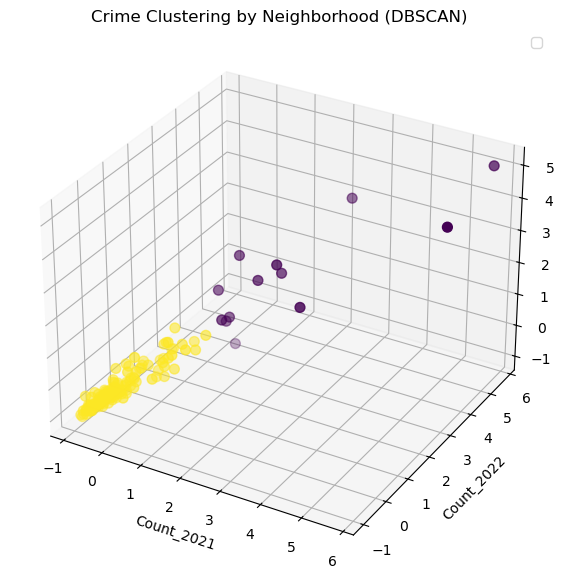

In [51]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create a 3D plot of the clusters
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot each cluster with a different color (-1 will be for outliers)
ax.scatter(X_scaled[:, 0], X_scaled[:, 1], X_scaled[:, 2], c=clusters, cmap='viridis', s=50)

# Add labels
ax.set_xlabel('Count_2021')
ax.set_ylabel('Count_2022')
ax.set_zlabel('Count_2023')
ax.legend(loc='best')
plt.title('Crime Clustering by Neighborhood (DBSCAN)')
plt.show()
